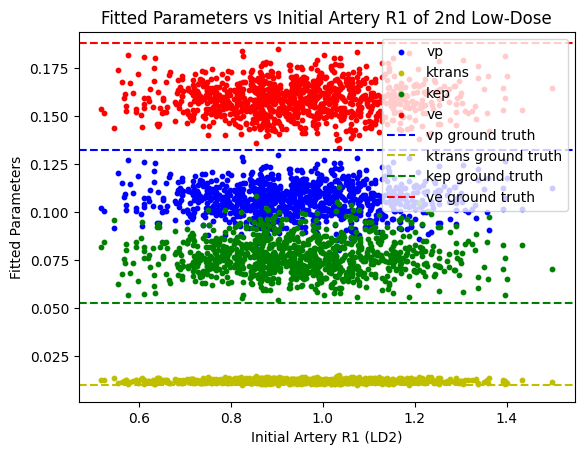

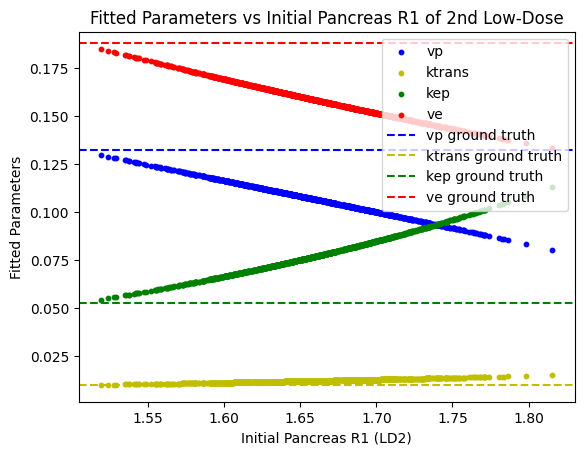

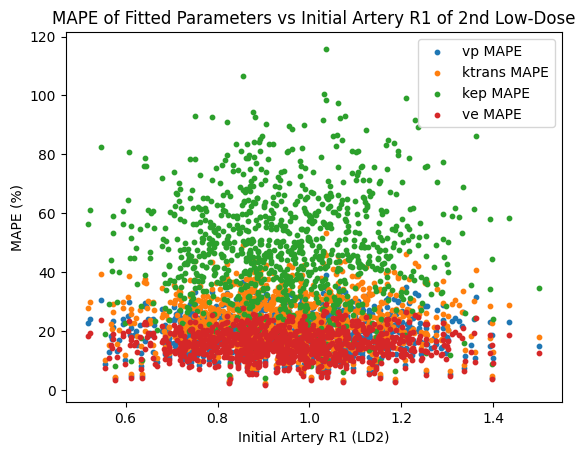

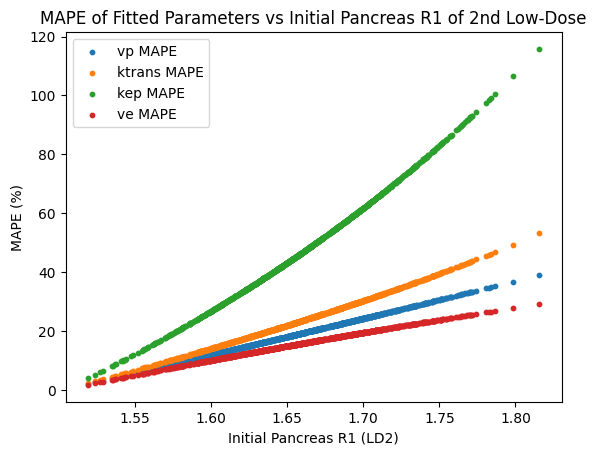

In [13]:
import sys
sys.path.append("../")
from dataset import extended_tofts

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the .mat file
data = scipy.io.loadmat('data.mat')

# Extract variables from data
R1_artery_LD1_0 = data['R1_artery_LD1_0'].item()
R1_artery_LD2_0 = data['R1_artery_LD2_0'].item()
R1_artery_decay = data['R1_artery_decay'].flatten()

R1_pancreas_LD1_0 = data['R1_pancreas_LD1_0'].item()
R1_pancreas_LD2_0 = data['R1_pancreas_LD2_0'].item()
R1_pancreas_decay = data['R1_pancreas_decay'].flatten()

# Artery calculations
R1_artery_enhance = np.linspace(R1_artery_LD1_0, R1_artery_decay[0], 10)
R1_artery = np.concatenate((R1_artery_enhance, R1_artery_decay))

std_artery = abs(R1_artery_LD1_0 - R1_artery_LD2_0) / 3

R1_pancreas_enhance = np.linspace(R1_pancreas_LD1_0, R1_pancreas_decay[0], 10)
R1_pancreas = np.concatenate((R1_pancreas_enhance, R1_pancreas_decay))
std_pancreas = abs(R1_pancreas_LD1_0 - R1_pancreas_LD2_0) / 3

# Define the extended Tofts model
def extended_tofts(aif, vp, ktrans, kep, dt=2.0608):
    t = np.arange(len(aif)) * dt
    kernel = np.exp(-kep * t)
    conv_result = np.convolve(aif, kernel, mode='full')[:len(aif)] * dt
    return vp * aif + ktrans * conv_result

# Fit ground truth
aif_gt = (R1_artery - R1_artery_LD1_0) / 0.6
c_pancreas_gt = R1_pancreas - R1_pancreas_LD1_0

def model_func(t, vp, ktrans, kep):
    return extended_tofts(aif_gt, vp, ktrans, kep)

gt_popt, _ = curve_fit(model_func, np.arange(len(c_pancreas_gt)), c_pancreas_gt, p0=[0.1, 0.1, 0.1])
vp_gt, ktrans_gt, kep_gt = gt_popt
ve_gt = ktrans_gt / kep_gt

# Storage for results
results = []

for _ in range(1000):
    R1_artery_LD2_sim_0 = R1_artery_LD2_0 + np.random.randn() * std_artery
    R1_pancreas_LD2_sim_0 = R1_pancreas_LD2_0 + np.random.randn() * std_pancreas

    R1_artery_enhance_sim = np.linspace(R1_artery_LD2_sim_0, R1_artery_decay[0], 10)
    R1_artery_sim = np.concatenate((R1_artery_enhance_sim, R1_artery_decay))

    R1_pancreas_enhance_sim = np.linspace(R1_pancreas_LD2_sim_0, R1_pancreas_decay[0], 10)
    R1_pancreas_sim = np.concatenate((R1_pancreas_enhance_sim, R1_pancreas_decay))

    aif = (R1_artery_sim - R1_artery_LD2_sim_0) / 0.6
    c_pancreas = R1_pancreas_sim - R1_pancreas_LD2_sim_0

    popt, _ = curve_fit(model_func, np.arange(len(c_pancreas)), c_pancreas, p0=[0.1, 0.1, 0.1])
    vp, ktrans, kep = popt
    ve = ktrans / kep
    
    results.append((R1_artery_LD2_sim_0, R1_pancreas_LD2_sim_0, vp, ktrans, kep, ve))

# Convert results to arrays for plotting
results = np.array(results)
R1_artery_LD2_sim_0_vals, R1_pancreas_LD2_sim_0_vals, vp_vals, ktrans_vals, kep_vals, ve_vals = results.T

# Compute mean absolute percentage error (MAPE)
mape_vp = np.abs((vp_vals - vp_gt) / vp_gt) * 100
mape_ktrans = np.abs((ktrans_vals - ktrans_gt) / ktrans_gt) * 100
mape_kep = np.abs((kep_vals - kep_gt) / kep_gt) * 100
mape_ve = np.abs((ve_vals - ve_gt) / ve_gt) * 100

# Plot scatter figures with smaller dots
plt.figure()
plt.scatter(R1_artery_LD2_sim_0_vals, vp_vals, color='b', s=10, label='vp')
plt.scatter(R1_artery_LD2_sim_0_vals, ktrans_vals,  color='y', s=10, label='ktrans')
plt.scatter(R1_artery_LD2_sim_0_vals, kep_vals,  color='g', s=10, label='kep')
plt.scatter(R1_artery_LD2_sim_0_vals, ve_vals,  color='r', s=10, label='ve')
plt.axhline(y=vp_gt, color='b', linestyle='--', label='vp ground truth')
plt.axhline(y=ktrans_gt, color='y', linestyle='--', label='ktrans ground truth')
plt.axhline(y=kep_gt, color='g', linestyle='--', label='kep ground truth')
plt.axhline(y=ve_gt, color='r', linestyle='--', label='ve ground truth')
plt.xlabel('Initial Artery R1 (LD2)')
plt.ylabel('Fitted Parameters')
plt.legend()
plt.title('Fitted Parameters vs Initial Artery R1 of 2nd Low-Dose')
plt.show()


plt.figure()
plt.scatter(R1_pancreas_LD2_sim_0_vals, vp_vals,color='b', s=10, label='vp')
plt.scatter(R1_pancreas_LD2_sim_0_vals, ktrans_vals, color='y',s=10, label='ktrans')
plt.scatter(R1_pancreas_LD2_sim_0_vals, kep_vals, color='g', s=10, label='kep')
plt.scatter(R1_pancreas_LD2_sim_0_vals, ve_vals,color='r',  s=10, label='ve')
plt.axhline(y=vp_gt, color='b', linestyle='--', label='vp ground truth')
plt.axhline(y=ktrans_gt, color='y', linestyle='--', label='ktrans ground truth')
plt.axhline(y=kep_gt, color='g', linestyle='--', label='kep ground truth')
plt.axhline(y=ve_gt, color='r', linestyle='--', label='ve ground truth')
plt.xlabel('Initial Pancreas R1 (LD2)')
plt.ylabel('Fitted Parameters')
plt.legend()
plt.title('Fitted Parameters vs Initial Pancreas R1 of 2nd Low-Dose')
plt.show()

# Plot MAPE
plt.figure()
plt.scatter(R1_artery_LD2_sim_0_vals, mape_vp, s=10, label='vp MAPE')
plt.scatter(R1_artery_LD2_sim_0_vals, mape_ktrans, s=10, label='ktrans MAPE')
plt.scatter(R1_artery_LD2_sim_0_vals, mape_kep, s=10, label='kep MAPE')
plt.scatter(R1_artery_LD2_sim_0_vals, mape_ve, s=10, label='ve MAPE')
plt.xlabel('Initial Artery R1 (LD2)')
plt.ylabel('MAPE (%)')
plt.legend()
plt.title('MAPE of Fitted Parameters vs Initial Artery R1 of 2nd Low-Dose')
plt.show()

# Plot MAPE
plt.figure()
plt.scatter(R1_pancreas_LD2_sim_0_vals, mape_vp, s=10, label='vp MAPE')
plt.scatter(R1_pancreas_LD2_sim_0_vals, mape_ktrans, s=10, label='ktrans MAPE')
plt.scatter(R1_pancreas_LD2_sim_0_vals, mape_kep, s=10, label='kep MAPE')
plt.scatter(R1_pancreas_LD2_sim_0_vals, mape_ve, s=10, label='ve MAPE')
plt.xlabel('Initial Pancreas R1 (LD2)')
plt.ylabel('MAPE (%)')
plt.legend()
plt.title('MAPE of Fitted Parameters vs Initial Pancreas R1 of 2nd Low-Dose')
plt.show()

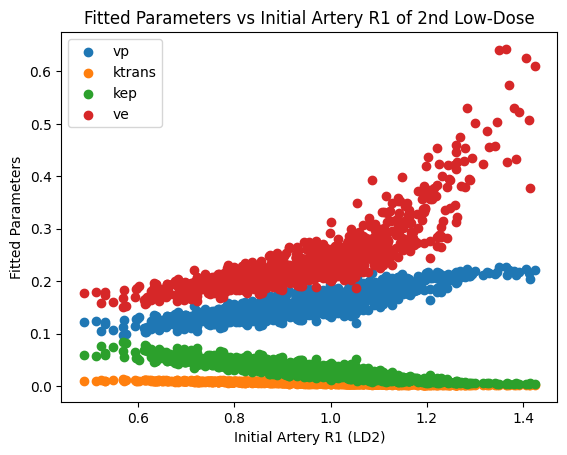

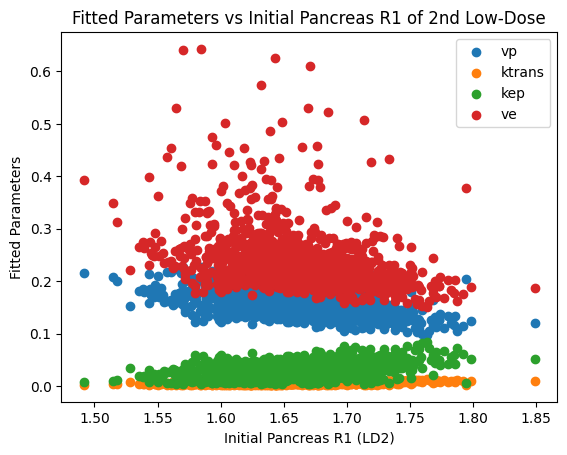

In [12]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the .mat file
data = scipy.io.loadmat('data.mat')

# Extract variables from data
R1_artery_LD1_0 = data['R1_artery_LD1_0'].item()
R1_artery_LD2_0 = data['R1_artery_LD2_0'].item()
R1_artery_decay = data['R1_artery_decay'].flatten()

R1_pancreas_LD1_0 = data['R1_pancreas_LD1_0'].item()
R1_pancreas_LD2_0 = data['R1_pancreas_LD2_0'].item()
R1_pancreas_decay = data['R1_pancreas_decay'].flatten()

# Artery calculations
R1_artery_enhance = np.linspace(R1_artery_LD1_0, R1_artery_decay[0], 10)
R1_artery = np.concatenate((R1_artery_enhance, R1_artery_decay))

std_artery = abs(R1_artery_LD1_0 - R1_artery_LD2_0) / 3
std_pancreas = abs(R1_pancreas_LD1_0 - R1_pancreas_LD2_0) / 3

# Define the extended Tofts model
def extended_tofts(aif, vp, ktrans, kep, dt=2.0608):
    t = np.arange(len(aif)) * dt
    kernel = np.exp(-kep * t)
    conv_result = np.convolve(aif, kernel, mode='full')[:len(aif)] * dt
    return vp * aif + ktrans * conv_result

# Storage for results
results = []

for _ in range(1000):
    R1_artery_LD2_sim_0 = R1_artery_LD2_0 + np.random.randn() * std_artery
    R1_pancreas_LD2_sim_0 = R1_pancreas_LD2_0 + np.random.randn() * std_pancreas

    R1_artery_enhance_sim = np.linspace(R1_artery_LD2_sim_0, R1_artery_decay[0], 10)
    R1_artery_sim = np.concatenate((R1_artery_enhance_sim, R1_artery_decay))

    R1_pancreas_enhance_sim = np.linspace(R1_pancreas_LD2_sim_0, R1_pancreas_decay[0], 10)
    R1_pancreas_sim = np.concatenate((R1_pancreas_enhance_sim, R1_pancreas_decay))

    aif = (R1_artery_sim - R1_artery_LD2_sim_0) / 0.6
    c_pancreas = R1_pancreas_sim - R1_pancreas_LD2_sim_0

    # Fit vp, ktrans, kep using curve fitting
    def model_func(t, vp, ktrans, kep):
        return extended_tofts(aif, vp, ktrans, kep)
    
    popt, _ = curve_fit(model_func, np.arange(len(c_pancreas)), c_pancreas, p0=[0.1, 0.1, 0.1])
    vp, ktrans, kep = popt
    ve = ktrans / kep
    
    results.append((R1_artery_LD2_sim_0, R1_pancreas_LD2_sim_0, vp, ktrans, kep, ve))

# Convert results to arrays for plotting
results = np.array(results)
R1_artery_LD2_sim_0_vals, R1_pancreas_LD2_sim_0_vals, vp_vals, ktrans_vals, kep_vals, ve_vals = results.T

# Plot results
plt.figure()
plt.scatter(R1_artery_LD2_sim_0_vals, vp_vals, label='vp')
plt.scatter(R1_artery_LD2_sim_0_vals, ktrans_vals, label='ktrans')
plt.scatter(R1_artery_LD2_sim_0_vals, kep_vals, label='kep')
plt.scatter(R1_artery_LD2_sim_0_vals, ve_vals, label='ve')
plt.xlabel('Initial Artery R1 (LD2)')
plt.ylabel('Fitted Parameters')
plt.legend()
plt.title('Fitted Parameters vs Initial Artery R1 of 2nd Low-Dose')
plt.show()

plt.figure()
plt.scatter(R1_pancreas_LD2_sim_0_vals, vp_vals, label='vp')
plt.scatter(R1_pancreas_LD2_sim_0_vals, ktrans_vals, label='ktrans')
plt.scatter(R1_pancreas_LD2_sim_0_vals, kep_vals, label='kep')
plt.scatter(R1_pancreas_LD2_sim_0_vals, ve_vals, label='ve')
plt.xlabel('Initial Pancreas R1 (LD2)')
plt.ylabel('Fitted Parameters')
plt.legend()
plt.title('Fitted Parameters vs Initial Pancreas R1 of 2nd Low-Dose')
plt.show()
